# NSE Stock Forecast Analysis with Deep Learning

**Goal:** This notebook analyzes historical stock data for a selected NSE ticker, applies technical indicators, and builds two deep learning models (CNN and LSTM) to forecast future prices.

**Methodology:**
1.  **Data Loading:** Fetch 5 years of historical stock data from Yahoo Finance.
2.  **Technical Analysis:** Calculate and visualize MACD and RSI indicators.
3.  **Model Training:** Train both a 1D-CNN and an LSTM model to predict a 15-day future price sequence.
4.  **Forecasting & Comparison:** Generate and plot the forecasts from both models.
5.  **Backtesting:** Evaluate the model's performance on historical unseen data using a proper backtesting methodology.

In [1]:
# 1. All Imports
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, LSTM, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from IPython.display import display

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Configuration
Here, you can set the stock ticker you want to analyze. The entire notebook will run for this selection.

In [12]:
# --- Static List of Tickers ---
nse_tickers = {
    "RELIANCE": "RELIANCE.NS",
    "TCS": "TCS.NS",
    "INFY": "INFY.NS",
    "HDFCBANK": "HDFCBANK.NS",
    "ICICIBANK": "ICICIBANK.NS",
    "HINDUNILVR": "HINDUNILVR.NS",
    "SBIN": "SBIN.NS",
    "ITC": "ITC.NS",
    "SHRIRAMFIN": "SHRIRAMFIN.NS",
    "LT": "LT.NS"
}

# --- Main Configuration ---
STOCK_NAME = "HDFCBANK" # <-- CHANGE THIS VALUE TO ANALYZE A DIFFERENT STOCK
TICKER = nse_tickers[STOCK_NAME]
WINDOW_SIZE = 60
FORECAST_DAYS = 15

print(f"Configuration set for: {STOCK_NAME} ({TICKER})")

Configuration set for: HDFCBANK (HDFCBANK.NS)


## 3. Data Loading and Initial Analysis
We'll download 5 years of historical data for our selected stock and display its recent trend.

[*********************100%***********************]  1 of 1 completed

Data downloaded for HDFCBANK.NS. Shape: (1240, 1)
Ticker      HDFCBANK.NS
Date                   
2020-10-05   527.742615
2020-10-06   541.831909
2020-10-07   550.427368
2020-10-08   564.421997
2020-10-09   584.194275


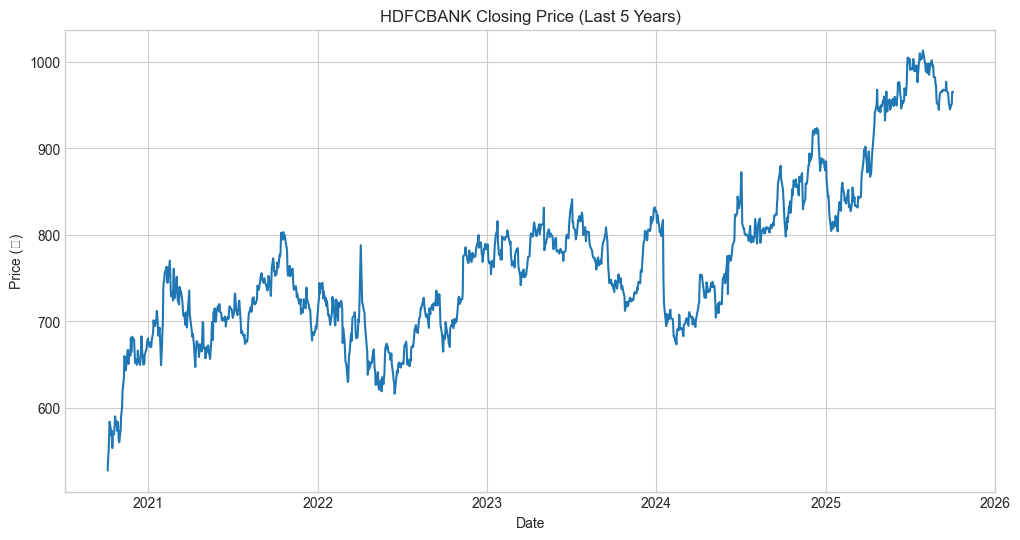

Ticker,HDFCBANK.NS
Date,
2025-09-29,950.299988
2025-09-30,951.000000
2025-10-01,965.250000
2025-10-02,965.250000
2025-10-03,965.150024


In [13]:
import warnings 

warnings.filterwarnings("ignore")

# Download historical data
data_all = yf.download(TICKER, period="5y", auto_adjust=True)
data = data_all['Close'].dropna()

print(f"Data downloaded for {TICKER}. Shape: {data.shape}")
print(data.head())

# Plot the recent closing prices
plt.figure(figsize=(12, 6))
plt.title(f'{STOCK_NAME} Closing Price (Last 5 Years)')
plt.plot(data)
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.show()

display(data.tail())

## 4. Technical Analysis
We will now calculate and visualize two popular technical indicators: **MACD** (Moving Average Convergence Divergence) and **RSI** (Relative Strength Index).

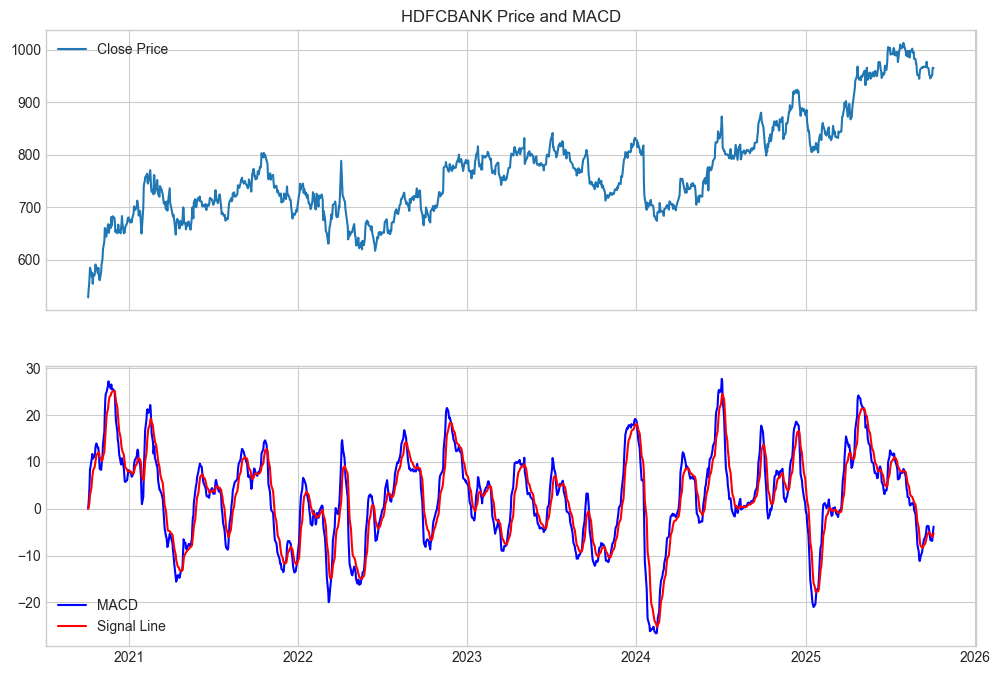

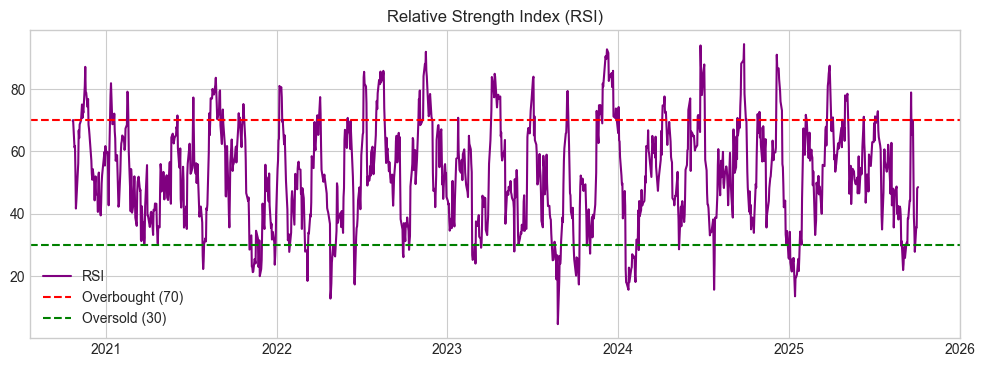

In [14]:
def add_technical_indicators(df):
    df_copy = df.copy()
    # MACD
    df_copy['EMA12'] = df_copy['Close'].ewm(span=12, adjust=False).mean()
    df_copy['EMA26'] = df_copy['Close'].ewm(span=26, adjust=False).mean()
    df_copy['MACD'] = df_copy['EMA12'] - df_copy['EMA26']
    df_copy['Signal_Line'] = df_copy['MACD'].ewm(span=9, adjust=False).mean()

    # RSI
    delta = df_copy['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df_copy['RSI'] = 100 - (100 / (1 + rs))
    return df_copy

indicators_df = add_technical_indicators(data_all)

# Plot MACD
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axs[0].plot(indicators_df['Close'], label="Close Price")
axs[0].set_title(f"{STOCK_NAME} Price and MACD")
axs[0].legend()
axs[1].plot(indicators_df['MACD'], label="MACD", color="blue")
axs[1].plot(indicators_df['Signal_Line'], label="Signal Line", color="red")
axs[1].legend()
plt.show()

# Plot RSI
fig_rsi, ax_rsi = plt.subplots(figsize=(12, 4))
ax_rsi.plot(indicators_df['RSI'], label="RSI", color="purple")
ax_rsi.axhline(70, color='red', linestyle='--', label='Overbought (70)')
ax_rsi.axhline(30, color='green', linestyle='--', label='Oversold (30)')
ax_rsi.set_title("Relative Strength Index (RSI)")
ax_rsi.legend()
plt.show()

## 5. Deep Learning Forecasting
We will now build, train, and generate forecasts using two different deep learning architectures: a 1D Convolutional Neural Network (CNN) and a Long Short-Term Memory (LSTM) network.

In [15]:
# --- Data Preparation ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

def create_sequences(data, window_size, forecast_days):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_days):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + forecast_days].flatten())
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, WINDOW_SIZE, FORECAST_DAYS)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (932, 60, 1)
Test data shape: (233, 60, 1)


In [16]:
# --- 5.1: CNN Model ---
print("--- Training CNN Model ---")
cnn_model = Sequential([
    Input(shape=(WINDOW_SIZE, 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(FORECAST_DAYS)
])
cnn_model.compile(optimizer=Adam(0.001), loss='mse')
cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# --- 5.2: LSTM Model ---
print("\n--- Training LSTM Model ---")
lstm_model = Sequential([
    Input(shape=(WINDOW_SIZE, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(FORECAST_DAYS)
])
lstm_model.compile(optimizer=Adam(0.001), loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

--- Training CNN Model ---
Epoch 1/20
27/27 [==============================] - 0s 3ms/step - loss: 0.0384 - val_loss: 0.0081
Epoch 2/20
27/27 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 0.0133
Epoch 3/20
27/27 [==============================] - 0s 1ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 4/20
27/27 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 5/20
27/27 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 6/20
27/27 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0063
Epoch 7/20
27/27 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0096
Epoch 8/20
27/27 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0093
Epoch 9/20
27/27 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 10/20
27/27 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss:

Epoch 1/20
27/27 [==============================] - 1s 19ms/step - loss: 0.0778 - val_loss: 0.0453
Epoch 2/20
27/27 [==============================] - 0s 13ms/step - loss: 0.0169 - val_loss: 0.0170
Epoch 3/20
27/27 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.0224
Epoch 4/20
27/27 [==============================] - 0s 12ms/step - loss: 0.0098 - val_loss: 0.0127
Epoch 5/20
27/27 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0125
Epoch 6/20
27/27 [==============================] - 0s 12ms/step - loss: 0.0078 - val_loss: 0.0101
Epoch 7/20
27/27 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 8/20
27/27 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0082
Epoch 9/20
27/27 [==============================] - 0s 12ms/step - loss: 0.0065 - val_loss: 0.0076
Epoch 10/20
27/27 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 11/

## 6. Forecast Comparison
Now, we take the last `WINDOW_SIZE` days of data, predict the next `FORECAST_DAYS`, and plot the results from both models against the recent historical price.

1/1 [==============================] - 0s 197ms/step


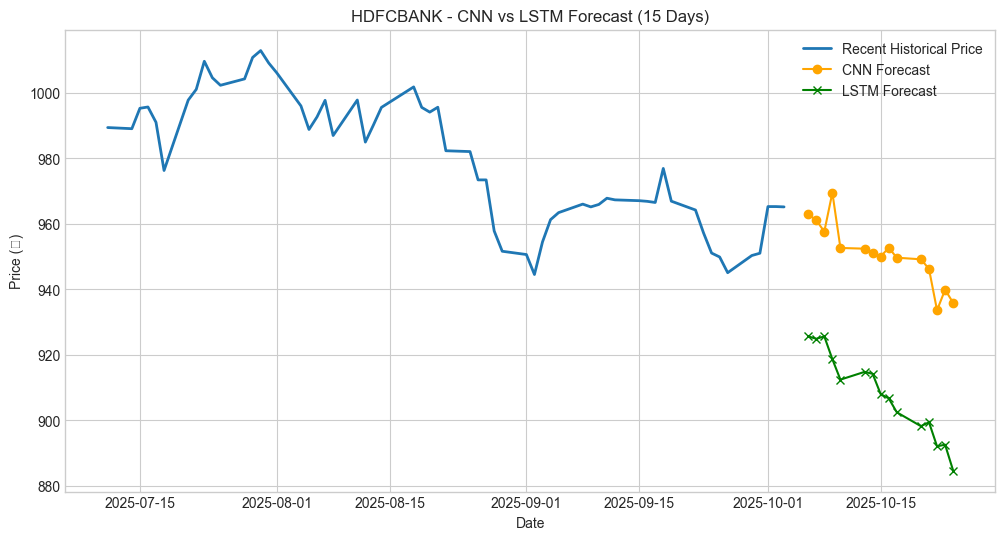

Forecasted Prices for the next 15 business days:


,CNN Forecast (₹),LSTM Forecast (₹)
Date,,
2025-10-06 00:00:00,962.94,925.59
2025-10-07 00:00:00,961.06,924.86
2025-10-08 00:00:00,957.62,925.59
2025-10-09 00:00:00,969.50,918.63
2025-10-10 00:00:00,952.61,912.39
2025-10-13 00:00:00,952.39,914.75
2025-10-14 00:00:00,951.14,914.16
2025-10-15 00:00:00,949.97,907.96
2025-10-16 00:00:00,952.68,906.67


In [17]:
# --- Generate Forecasts ---
last_sequence = scaled_data[-WINDOW_SIZE:].reshape(1, WINDOW_SIZE, 1)

# CNN forecast
forecast_scaled_cnn = cnn_model.predict(last_sequence)[0]
forecast_cnn = scaler.inverse_transform(forecast_scaled_cnn.reshape(-1, 1)).flatten()

# LSTM forecast
forecast_scaled_lstm = lstm_model.predict(last_sequence)[0]
forecast_lstm = scaler.inverse_transform(forecast_scaled_lstm.reshape(-1, 1)).flatten()

# Create forecast dates
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=FORECAST_DAYS, freq='B')

# --- Plot Comparison ---
plt.figure(figsize=(12, 6))
plt.plot(data.index[-60:], data.values[-60:], label="Recent Historical Price", linewidth=2)
plt.plot(forecast_dates, forecast_cnn, label="CNN Forecast", color='orange', marker='o')
plt.plot(forecast_dates, forecast_lstm, label="LSTM Forecast", color='green', marker='x')
plt.title(f"{STOCK_NAME} - CNN vs LSTM Forecast ({FORECAST_DAYS} Days)")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.show()

# --- Display Forecast in a DataFrame ---
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "CNN Forecast (₹)": forecast_cnn,
    "LSTM Forecast (₹)": forecast_lstm
}).set_index("Date")
print(f"Forecasted Prices for the next {FORECAST_DAYS} business days:")
display(forecast_df.style.format("{:.2f}"))

## 7. Backtesting (Corrected Methodology)

Backtesting evaluates how a model *would have* performed on historical data. The correct way to do this is to train a model once on the training set, and then use that single trained model to make predictions on multiple periods from the unseen test set.

**Note:** The original app's backtest was flawed as it re-created an untrained model for each prediction. The method below is the correct approach.

Performing backtest on the test set, which has 233 samples.
1/1 [==============================] - 0s 7ms/step


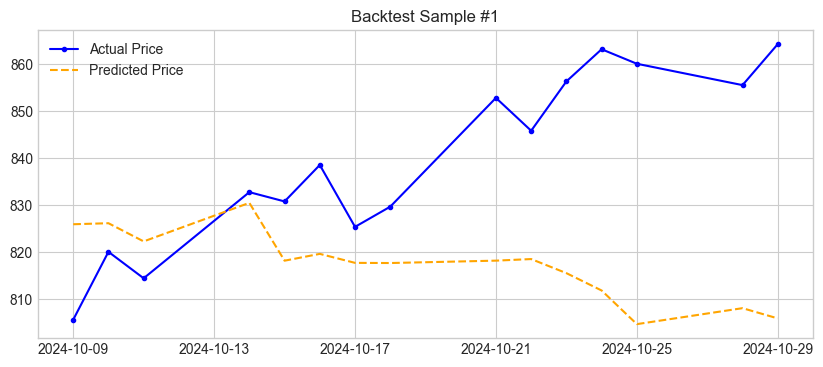

1/1 [==============================] - 0s 7ms/step


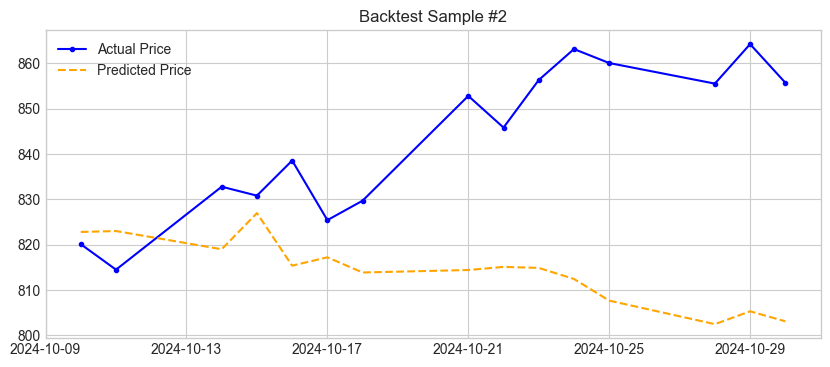

1/1 [==============================] - 0s 8ms/step


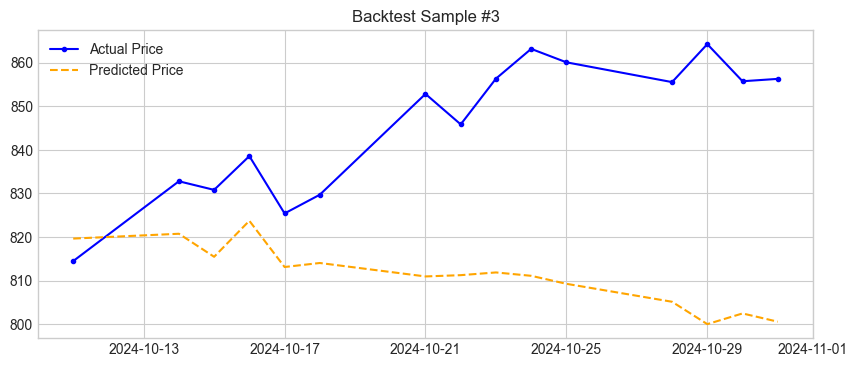

1/1 [==============================] - 0s 21ms/step


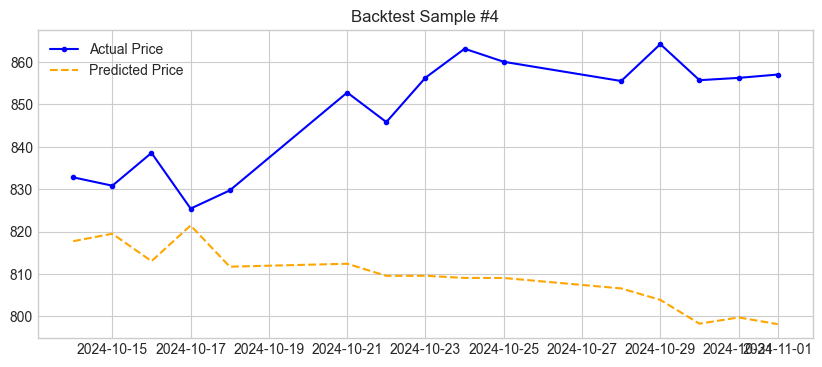

1/1 [==============================] - 0s 8ms/step


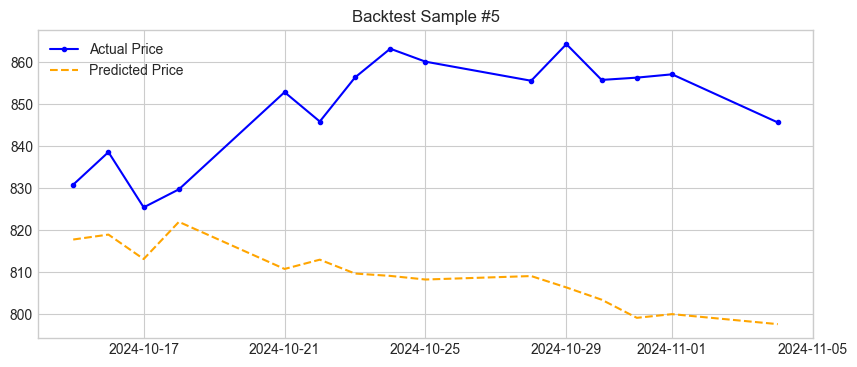

In [18]:
# We will use our already trained CNN model for this backtest.
print(f"Performing backtest on the test set, which has {len(X_test)} samples.")

# We'll show up to 5 backtest samples from the test set.
max_samples = min(5, len(X_test))

for i in range(max_samples):
    # Select a sample from the test set
    sample_X = X_test[i].reshape(1, WINDOW_SIZE, 1)
    sample_y_true_scaled = y_test[i]
    
    # Predict using the TRAINED model
    sample_pred_scaled = cnn_model.predict(sample_X)[0]
    
    # Inverse transform to get actual prices
    sample_pred = scaler.inverse_transform(sample_pred_scaled.reshape(-1, 1)).flatten()
    sample_y_true = scaler.inverse_transform(sample_y_true_scaled.reshape(-1, 1)).flatten()
    
    # Get the dates for this backtest period
    # The start date of the true values is WINDOW_SIZE days after the start of the test data
    start_idx = train_size + i
    backtest_dates = data.index[start_idx + WINDOW_SIZE : start_idx + WINDOW_SIZE + FORECAST_DAYS]
    
    # Plot the backtest sample
    plt.figure(figsize=(10, 4))
    plt.plot(backtest_dates, sample_y_true, label="Actual Price", color="blue", marker='.')
    plt.plot(backtest_dates, sample_pred, label="Predicted Price", color="orange", linestyle='--')
    plt.title(f"Backtest Sample #{i+1}")
    plt.legend()
    plt.show()

In [19]:
import warnings
warnings.filterwarnings("ignore")

# --- Add this cell to your notebook to calculate metrics ---
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate CNN Model on the test set
y_pred_cnn_scaled = cnn_model.predict(X_test)
y_pred_cnn = scaler.inverse_transform(y_pred_cnn_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, FORECAST_DAYS))

cnn_rmse = np.sqrt(mean_squared_error(y_true, y_pred_cnn))
cnn_mae = mean_absolute_error(y_true, y_pred_cnn)

# Evaluate LSTM Model on the test set
y_pred_lstm_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled)

lstm_rmse = np.sqrt(mean_squared_error(y_true, y_pred_lstm))
lstm_mae = mean_absolute_error(y_true, y_pred_lstm)

print(f"CNN Model - Test RMSE: {cnn_rmse:.2f}, Test MAE: {cnn_mae:.2f}")
print(f"LSTM Model - Test RMSE: {lstm_rmse:.2f}, Test MAE: {lstm_mae:.2f}")

8/8 [==============================] - 0s 4ms/step
CNN Model - Test RMSE: 46.95, Test MAE: 39.02
LSTM Model - Test RMSE: 51.37, Test MAE: 44.02
